>> Membuat embedding dan menyimpan ke file...


Device set to use cuda:0
C:\Users\SOC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


calculating scores...
computing bert embedding.


100%|██████████| 3/3 [00:39<00:00, 13.10s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00, 13.51it/s]


done in 39.46 seconds, 2.53 sentences/sec

=== EVALUASI BERTScore (IndoBERT hasil reranking) ===
Precision: 0.8279
Recall   : 0.8287
F1 Score : 0.8277


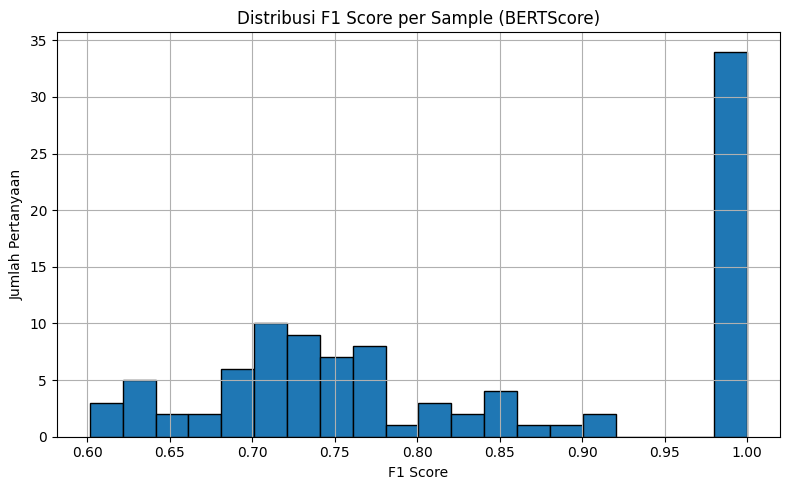

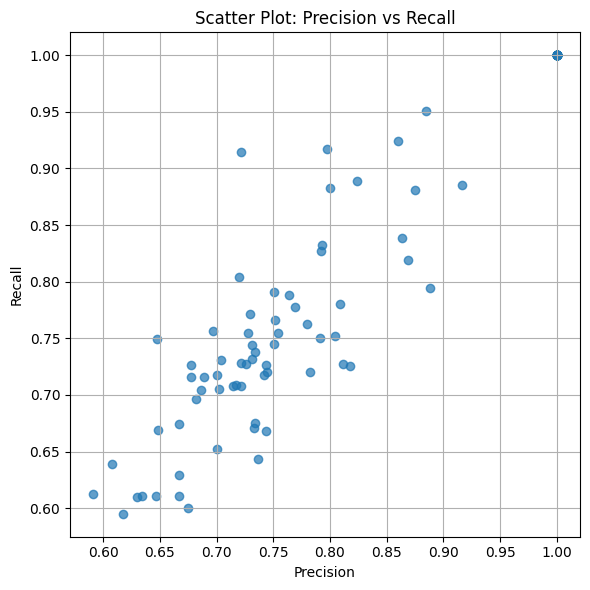

In [2]:
from sentence_transformers import SentenceTransformer, util
from transformers import TextClassificationPipeline, AutoTokenizer, AutoModelForSequenceClassification
from bert_score import score
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import os

# === 1. Fungsi Pembersih Teks ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s\?\.,]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# === 2. Load dan Bersihkan Data ===
df = pd.read_csv("data04.csv")
df['Pertanyaan'] = df['Pertanyaan'].astype(str).apply(clean_text)
df['Jawaban'] = df['Jawaban'].astype(str).apply(clean_text)
jawaban_korpus = df['Jawaban'].tolist()

# === 3. Load SentenceTransformer dan Embedding ===
embed_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

embedding_file = "jawaban_embeddings.npy"
if os.path.exists(embedding_file):
    print(">> Loading embedding dari file...")
    jawaban_embeddings = torch.tensor(np.load(embedding_file))
    if torch.cuda.is_available():
        jawaban_embeddings = jawaban_embeddings.to("cuda")
else:
    print(">> Membuat embedding dan menyimpan ke file...")
    jawaban_embeddings = embed_model.encode(jawaban_korpus, convert_to_tensor=True)
    np.save(embedding_file, jawaban_embeddings.cpu().numpy())

# === 4. Load IndoBERT Fine-tuned Model ===
model = AutoModelForSequenceClassification.from_pretrained("./model-data/indobert_qa_finetuned")
tokenizer = AutoTokenizer.from_pretrained("./model-data/indobert_qa_finetuned")

pipeline_indobert = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True,
    function_to_apply="softmax",
    batch_size=32
)

# === 5. Fungsi: Retrieval + Reranking ===
def jawab_dengan_retrieval_dan_indobert(pertanyaan_user, top_k=20):
    pertanyaan_user = clean_text(pertanyaan_user)
    pertanyaan_embedding = embed_model.encode(pertanyaan_user, convert_to_tensor=True)
    skor = util.cos_sim(pertanyaan_embedding, jawaban_embeddings)[0]
    top_idx = torch.topk(skor, k=top_k).indices
    kandidat = [jawaban_korpus[i] for i in top_idx]

    pasangan = [{"text": pertanyaan_user, "text_pair": j} for j in kandidat]
    hasil_prediksi = pipeline_indobert(pasangan)
    skor_relevansi = [p[1]["score"] for p in hasil_prediksi]
    idx_terbaik = int(np.argmax(skor_relevansi))
    return kandidat[idx_terbaik], skor_relevansi[idx_terbaik]

# === 6. Evaluasi: Sampling 100 Pertanyaan ===
val_eval = df.sample(n=100, random_state=42).reset_index(drop=True)
jawaban_referensi = []
jawaban_prediksi = []

for _, row in val_eval.iterrows():
    pertanyaan = row['Pertanyaan']
    referensi = row['Jawaban']
    prediksi, _ = jawab_dengan_retrieval_dan_indobert(pertanyaan, top_k=20)
    jawaban_referensi.append(referensi)
    jawaban_prediksi.append(prediksi)

# === 7. Evaluasi BERTScore ===
P, R, F1 = score(jawaban_prediksi, jawaban_referensi, lang="id", verbose=True)

print("\n=== EVALUASI BERTScore (IndoBERT hasil reranking) ===")
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall   : {R.mean().item():.4f}")
print(f"F1 Score : {F1.mean().item():.4f}")

# === 8. Visualisasi Histogram F1 ===
plt.figure(figsize=(8, 5))
plt.hist(F1.tolist(), bins=20, edgecolor='black')
plt.title("Distribusi F1 Score per Sample (BERTScore)")
plt.xlabel("F1 Score")
plt.ylabel("Jumlah Pertanyaan")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Visualisasi Scatter Precision vs Recall ===
plt.figure(figsize=(6, 6))
plt.scatter(P.tolist(), R.tolist(), alpha=0.7)
plt.title("Scatter Plot: Precision vs Recall")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
while True:
    user_input = input("Pertanyaan Anda (ketik 'exit' untuk keluar): ")
    if user_input.lower() == "exit":
        break
    jawaban, skor = jawab_dengan_retrieval_dan_indobert(user_input, top_k=20)
    print("Jawaban Chatbot:", jawaban)
    print("Skor Relevansi IndoBERT:", round(skor, 4))
    print("-" * 50)


Jawaban Chatbot: alamat lengkap klinik pratama mitra medicare berada di jl. dharma husada utara no.3638 blok gj, mojo, kec. gubeng, surabaya, jawa timur 60288
Skor Relevansi IndoBERT: 0.9999
--------------------------------------------------
Jawaban Chatbot: dapat mengetik antreansekarang
Skor Relevansi IndoBERT: 0.0008
--------------------------------------------------
Jawaban Chatbot: dapat mengetik antreansekarang
Skor Relevansi IndoBERT: 0.0068
--------------------------------------------------
Jawaban Chatbot: saat ini, klinik mitra medicare tidak menyediakan paket pemeriksaan gigi rutin. setiap pasien yang ingin melakukan pemeriksaan gigi perlu membayar biaya konsultasi dan tindakan secara terpisah, tergantung pada jenis layanan yang dibutuhkan. jika anda ingin mengetahui lebih lanjut mengenai layanan pemeriksaan gigi, anda dapat menghubungi bagian pendaftaran klinik atau langsung datang ke lokasi untuk berkonsultasi dengan dokter gigi yang bertugas.
Skor Relevansi IndoBERT: 0.99